In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

In [2]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Define the mapping of old codes to new codes
country_code_mapping = {
    'GR': 'EL',  # Greece (GR → EL)
    'GB': 'UK'   # United Kingdom (GB → UK)
}

# Apply the replacement to both columns
df['country_from'] = df['country_from'].replace(country_code_mapping)
df['country_to'] = df['country_to'].replace(country_code_mapping)

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [3]:
from eop_lite import CounterfactualConfig, compute_eop_lite

# ----------  A) STANDARDIZE YOUR SCHEMA  ----------
def standardize_user_schema(df: pd.DataFrame) -> pd.DataFrame:
    """
    Turns your columns into the 4 columns the EOP calculator expects:
      orig, dest, month (datetime at month start), flow
    Works whether your codes are ISO2 or ISO3 (just be consistent in triads).
    """
    df = df.copy()

    # If there is an integer 'month' column (1..12), rename it to avoid collision
    if 'month' in df.columns and pd.api.types.is_integer_dtype(df['month']):
        df = df.rename(columns={'month': 'month_num'})

    # Rename core columns
    rename_map = {
        'country_from': 'orig',
        'country_to': 'dest',
        'migration_month': 'month',
        'num_migrants': 'flow'
    }
    df = df.rename(columns=rename_map)

    # Keep only what we need
    keep = ['orig', 'dest', 'month', 'flow']
    df = df[keep]

    # Clean up codes and dates
    df['orig'] = df['orig'].astype(str).str.strip().str.upper()
    df['dest'] = df['dest'].astype(str).str.strip().str.upper()
    df['month'] = pd.to_datetime(df['month']).values.astype('datetime64[M]')  # month start
    df['flow'] = pd.to_numeric(df['flow'], errors='coerce').fillna(0).astype(float)

    return df


In [4]:
flows = standardize_user_schema(df)
flows

,orig,dest,month,flow
0,AD,AE,2019-01-01,12.0
1,AD,AE,2019-02-01,2.0
2,AD,AE,2019-03-01,1.0
3,AD,AE,2019-04-01,7.0
4,AD,AE,2019-05-01,0.0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138.0
1563150,ZW,ZM,2022-09-01,162.0
1563151,ZW,ZM,2022-10-01,149.0
1563152,ZW,ZM,2022-11-01,104.0


In [17]:
# ----------  C) DEFINE TRIADS (use the SAME code system as in your file) ----------
# Your snippet uses ISO2 (e.g., AD, AE). For your study, examples in ISO2:
triads = [
    ("VE","CL","US"),  # Venezuela -> Chile -> United States
    ("VE","PE","US"),  # Venezuela -> Peru  -> United States
    ("VE","EC","US"),  # Venezuela -> Ecuador -> United States
    ("VE","CO","US"),  # Venezuela -> Columbia -> United States
    ("VE","CL","ES"),  # Venezuela -> Chile -> Spain
    ("VE","PE","CL"),  # Venezuela -> Peru -> Chile
    ("CL","PE","VE"),  # Venezuela -> Peru -> Chile
    ("VE","PE","DE"),  # Venezuela -> Peru -> Chile
    ("VE","PE","UK"),  # Venezuela -> Peru -> Chile

    # ("HT","DO","US"),  # Haiti -> Dominican Republic -> United States
    # ("AR","UY","ES"),  # Argentina -> Uruguay -> Spain
    # ("SY","TR","DE"),  # Syria -> Türkiye -> Germany
]

In [18]:
# ----------  D) CONFIGURE THE COUNTERFACTUAL ----------
cfg = CounterfactualConfig(
    train_start="2019-01-01",        # training window for the baseline
    train_end="2021-12-01",
    corridor_specific_seasonality=False,  # flip to True if your corridors are not too sparse
    eps=1.0
)

In [19]:
# ----------  E) COMPUTE EOP-LITE ----------
eop = compute_eop_lite(flows, triads, cfg)
# Columns: ['i','j','k','month','flow_jk','ehat_jk','excess_jk','w_ij','eop_lite']
eop

,i,j,k,month,flow_jk,ehat_jk,excess_jk,w_ij,eop_lite
288,CL,PE,VE,2019-01-01,601.0,3909.087368,-0.846256,0.051415,-0.043510
289,CL,PE,VE,2019-02-01,896.0,5177.341653,-0.826938,0.053518,-0.044256
290,CL,PE,VE,2019-03-01,1103.0,5917.912338,-0.813617,0.057013,-0.046387
291,CL,PE,VE,2019-04-01,1488.0,3954.607263,-0.623730,0.052313,-0.032629
292,CL,PE,VE,2019-05-01,1763.0,3805.348957,-0.536705,0.048028,-0.025777
...,...,...,...,...,...,...,...,...,...
91,VE,PE,US,2022-08-01,11343.0,2239.366488,4.065272,0.432037,1.756349
92,VE,PE,US,2022-09-01,13345.0,2392.301787,4.578310,0.433824,1.986181
93,VE,PE,US,2022-10-01,16403.0,3196.429197,4.131664,0.428294,1.769568
94,VE,PE,US,2022-11-01,9258.0,2373.192094,2.901075,0.420579,1.220130


In [20]:
# ----------  G) SMALL SUMMARY SNIPPETS YOU CAN QUOTE ----------
# Peak month per triad
peaks = (eop.sort_values(['i','j','k','eop_lite'], ascending=[True,True,True,False])
           .groupby(['i','j','k']).head(1)[['i','j','k','month','eop_lite']])
print("\nPeak EOP‑Lite by triad:\n", peaks)


Peak EOP‑Lite by triad:
       i   j   k      month  eop_lite
320  CL  PE  VE 2021-09-01  0.107719
200  VE  CL  ES 2019-09-01  0.221966
32   VE  CL  US 2021-09-01  0.818437
187  VE  CO  US 2022-08-01  1.837138
127  VE  EC  US 2021-08-01  0.731977
276  VE  PE  CL 2022-01-01  0.644707
343  VE  PE  DE 2019-08-01  0.705471
392  VE  PE  UK 2019-09-01  0.869378
95   VE  PE  US 2022-12-01  2.293529


In [21]:
# 2022 means per triad (adjust year if needed)
eop['year'] = pd.to_datetime(eop['month']).dt.year
means_2022 = (eop[eop['year']==2022].groupby(['i','j','k'])['eop_lite'].mean().reset_index())
print("\n2022 mean EOP‑Lite by triad:\n", means_2022)


2022 mean EOP‑Lite by triad:
     i   j   k  eop_lite
0  CL  PE  VE  0.029298
1  VE  CL  ES  0.032320
2  VE  CL  US  0.172846
3  VE  CO  US  1.331286
4  VE  EC  US  0.101402
5  VE  PE  CL  0.083305
6  VE  PE  DE  0.037266
7  VE  PE  UK -0.131366
8  VE  PE  US  1.203113


# Plot

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# ----------  F) QUICK PLOTS FOR ONE TRIAD WITH POLICY LINE ----------
def plot_one_triad(eop_df, i, j, k, ma=3, policy_month=None, policy_name=None):
    # Ensure month column is datetime
    eop_df['month'] = pd.to_datetime(eop_df['month'])
    
    sub = (eop_df[(eop_df['i']==i) & (eop_df['j']==j) & (eop_df['k']==k)]
           .sort_values('month'))
    if sub.empty:
        print(f"No rows for triad {i}-{j}-{k}")
        return
    
    # Convert policy_month to datetime if given
    if policy_month is not None:
        policy_month = pd.to_datetime(policy_month)
    
    # Actual vs counterfactual for j->k
    plt.figure(figsize=(9,4))
    plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k')
    plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', linestyle='--')
    
    if policy_month is not None:
        plt.axvline(x=policy_month, color='red', linestyle=':', linewidth=2)
        if policy_name is not None:
            plt.text(policy_month, plt.ylim()[1]*0.9, policy_name, color='red', rotation=90, 
                     verticalalignment='top', horizontalalignment='right')
    
    plt.title(f"Actual vs Counterfactual for {j}→{k} (attribution from {i}→{j})")
    plt.xlabel("Month"); plt.ylabel("Monthly flow"); plt.legend(); plt.tight_layout(); plt.show()

    # EOP-Lite (moving average for readability)
    y = sub.set_index('month')['eop_lite'].rolling(ma, min_periods=1).mean()
    plt.figure(figsize=(9,3))
    plt.plot(y.index, y.values)
    plt.axhline(0, linewidth=1)
    
    if policy_month is not None:
        plt.axvline(x=policy_month, color='red', linestyle=':', linewidth=2)
        if policy_name is not None:
            plt.text(policy_month, plt.ylim()[1]*0.9, policy_name, color='red', rotation=90, 
                     verticalalignment='top', horizontalalignment='right')
    
    plt.title(f"EOP‑Lite ({ma}-month MA) for {i}→{j}→{k}")
    plt.xlabel("Month"); plt.ylabel("Index"); plt.tight_layout(); plt.show()


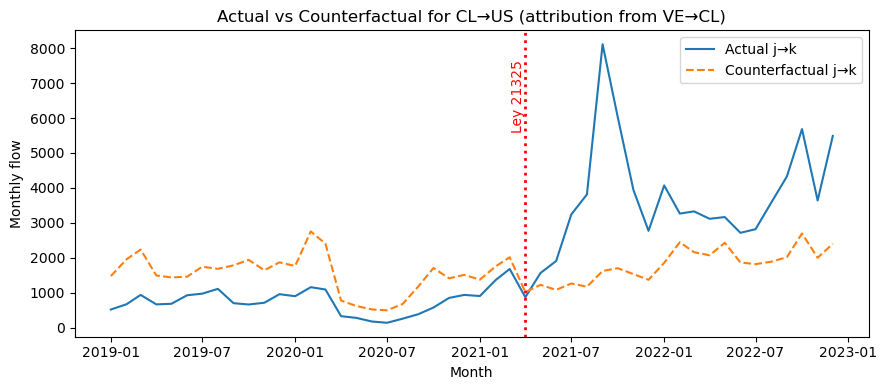

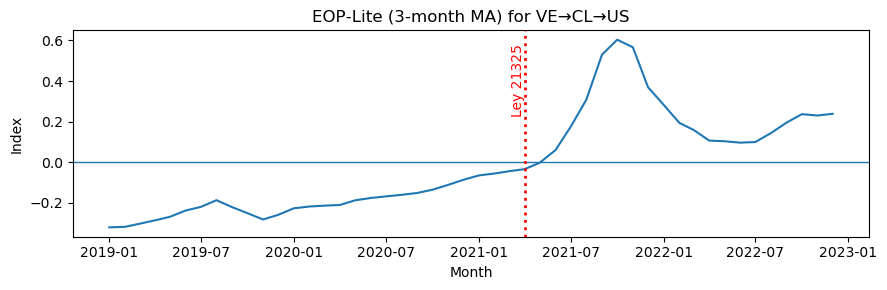

In [39]:
plot_one_triad(eop, i='VE', j='CL', k='US', policy_month='2021-04-01', policy_name='Ley 21325')

In [10]:
# ----------  F) QUICK PLOTS FOR ONE TRIAD ----------
def plot_one_triad(eop_df, i, j, k, ma=3):
    sub = (eop_df[(eop_df['i']==i) & (eop_df['j']==j) & (eop_df['k']==k)]
           .sort_values('month'))
    if sub.empty:
        print(f"No rows for triad {i}-{j}-{k}")
        return
    # Actual vs counterfactual for j->k
    plt.figure(figsize=(9,4))
    plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k')
    plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', linestyle='--')
    plt.title(f"Actual vs Counterfactual for {j}→{k} (attribution from {i}→{j})")
    plt.xlabel("Month"); plt.ylabel("Monthly flow"); plt.legend(); plt.tight_layout(); plt.show()

    # EOP-Lite (moving average for readability)
    y = sub.set_index('month')['eop_lite'].rolling(ma, min_periods=1).mean()
    plt.figure(figsize=(9,3))
    plt.plot(y.index, y.values)
    plt.axhline(0, linewidth=1)
    plt.title(f"EOP‑Lite ({ma}-month MA) for {i}→{j}→{k}")
    plt.xlabel("Month"); plt.ylabel("Index"); plt.tight_layout(); plt.show()

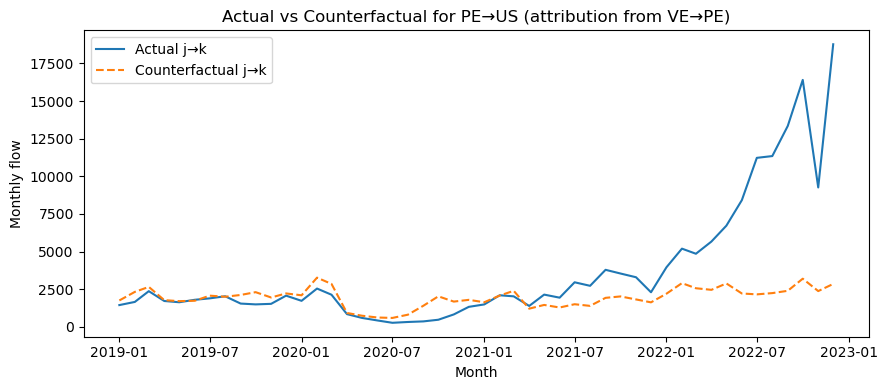

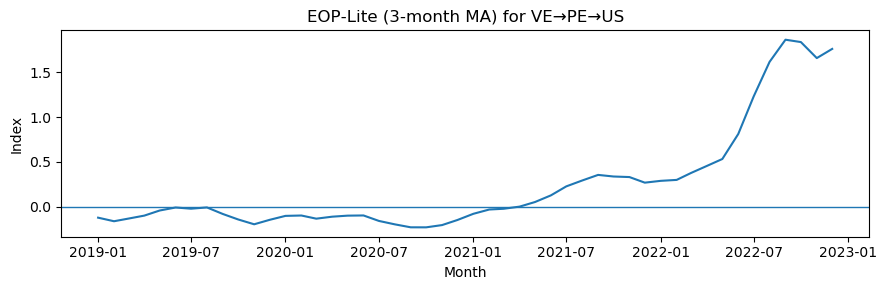

In [18]:
plot_one_triad(eop, "VE","PE","US")


Peak EOP‑Lite by triad:
       i   j   k      month  eop_lite
200  VE  CL  ES 2019-09-01  0.221966
32   VE  CL  US 2021-09-01  0.818437
187  VE  CO  US 2022-08-01  1.837138
127  VE  EC  US 2021-08-01  0.731977
276  VE  PE  CL 2022-01-01  0.644707
95   VE  PE  US 2022-12-01  2.293529



2022 mean EOP‑Lite by triad:
     i   j   k  eop_lite
0  VE  CL  ES  0.032320
1  VE  CL  US  0.172846
2  VE  CO  US  1.331286
3  VE  EC  US  0.101402
4  VE  PE  CL  0.083305
5  VE  PE  US  1.203113


# Example

In [5]:
import pandas as pd
from eop_lite import CounterfactualConfig, compute_eop_lite


In [8]:
# 1) Load your flows
df = pd.read_csv(BASE_DIR/"case_study/Migration/Excess_migration/flows_sample.csv")  # must have columns: orig, dest, month, flow
df

,orig,dest,month,flow
0,VEN,CHL,2019-01-01,2238
1,VEN,CHL,2019-02-01,2293
2,VEN,CHL,2019-03-01,2241
3,VEN,CHL,2019-04-01,2063
4,VEN,CHL,2019-05-01,2309
...,...,...,...,...
571,ECU,CHL,2022-08-01,180
572,ECU,CHL,2022-09-01,187
573,ECU,CHL,2022-10-01,187
574,ECU,CHL,2022-11-01,178


In [10]:
# 2) Choose triads
triads = [("VEN","CHL","USA"), ("VEN","PER","USA"), ("VEN","ECU","USA")]
triads

[('VEN', 'CHL', 'USA'), ('VEN', 'PER', 'USA'), ('VEN', 'ECU', 'USA')]

In [12]:
# 3) Configure (2019–2021 training → predict 2022)
cfg = CounterfactualConfig(
    train_start="2019-01-01",
    train_end="2021-12-01",
    corridor_specific_seasonality=True,  # set False to use global seasonality
    eps=1.0
)
cfg

CounterfactualConfig(train_start='2019-01-01', train_end='2021-12-01', corridor_specific_seasonality=True, eps=1.0)

In [14]:
# 4) Compute EOP‑Lite
eop_df = compute_eop_lite(df, triads, cfg)
eop_df

,i,j,k,month,flow_jk,ehat_jk,excess_jk,w_ij,eop_lite
0,VEN,CHL,USA,2019-01-01,252,253.379746,-0.005445,0.871495,-0.004746
1,VEN,CHL,USA,2019-02-01,244,242.880250,0.004610,0.869507,0.004009
2,VEN,CHL,USA,2019-03-01,246,265.834040,-0.074611,0.868316,-0.064786
3,VEN,CHL,USA,2019-04-01,221,228.919377,-0.034595,0.866686,-0.029983
4,VEN,CHL,USA,2019-05-01,275,262.644913,0.047041,0.867778,0.040821
...,...,...,...,...,...,...,...,...,...
91,VEN,PER,USA,2022-08-01,221,218.483797,0.011517,1.000000,0.011517
92,VEN,PER,USA,2022-09-01,219,207.201910,0.056940,1.000000,0.056940
93,VEN,PER,USA,2022-10-01,221,230.903232,-0.042889,1.000000,-0.042889
94,VEN,PER,USA,2022-11-01,226,233.938374,-0.033934,1.000000,-0.033934


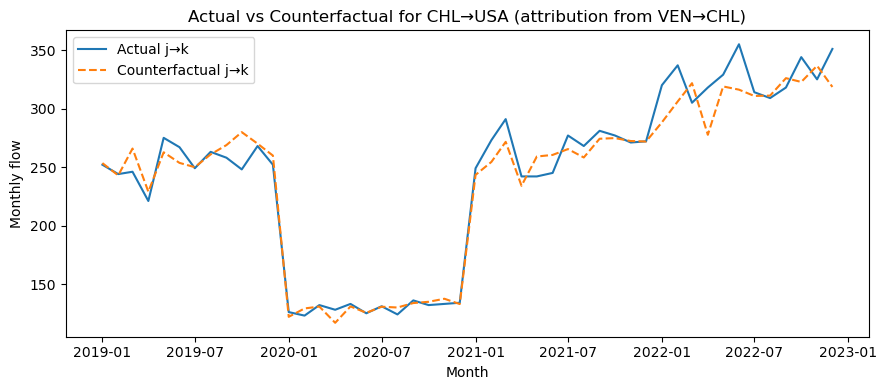

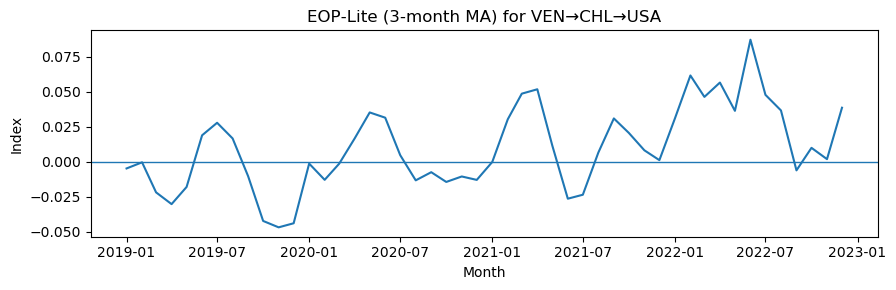

In [15]:
from eop_lite import compute_eop_lite  # already imported
import matplotlib.pyplot as plt

# Actual vs Counterfactual for j→k
sub = eop_df[(eop_df['i']=="VEN")&(eop_df['j']=="CHL")&(eop_df['k']=="USA")].sort_values('month')
plt.figure(figsize=(9,4))
plt.plot(sub['month'], sub['flow_jk'], label='Actual j→k')
plt.plot(sub['month'], sub['ehat_jk'], label='Counterfactual j→k', linestyle='--')
plt.title("Actual vs Counterfactual for CHL→USA (attribution from VEN→CHL)")
plt.xlabel("Month"); plt.ylabel("Monthly flow"); plt.legend(); plt.tight_layout(); plt.show()

# EOP‑Lite line (3‑month moving average)
y = sub.set_index('month')['eop_lite'].rolling(3, min_periods=1).mean()
plt.figure(figsize=(9,3))
plt.plot(y.index, y.values)
plt.axhline(0, linewidth=1)
plt.title("EOP‑Lite (3‑month MA) for VEN→CHL→USA")
plt.xlabel("Month"); plt.ylabel("Index"); plt.tight_layout(); plt.show()


In [18]:
# Peak months per triad
peaks = (eop_df.sort_values(['i','j','k','eop_lite'], ascending=[True,True,True,False])
         .groupby(['i','j','k'])
         .head(1)[['i','j','k','month','eop_lite']])
peaks

,i,j,k,month,eop_lite
39,VEN,CHL,USA,2022-04-01,0.127176
97,VEN,ECU,USA,2019-02-01,0.122460
65,VEN,PER,USA,2020-06-01,0.107233


In [19]:
# 2022 annual means per triad
eop_df['year'] = pd.to_datetime(eop_df['month']).dt.year
ann_2022 = (eop_df[eop_df['year']==2022]
            .groupby(['i','j','k'])['eop_lite'].mean().reset_index())
ann_2022

,i,j,k,eop_lite
0,VEN,CHL,USA,0.041557
1,VEN,ECU,USA,0.040231
2,VEN,PER,USA,0.020838
